# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [30]:
!pip install tensorflow
!pip install keras
!pip install sklearn
!pip install matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras

# The Dataset
> ***Brief Description:***
State the Problem and A short Description of the data


In [ ]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)

In [32]:
print("Loading dataset...")
df = pd.read_csv('/content/SCMS_Delivery_History_Dataset_20150929.csv', encoding='latin-1')

print("\nInitial dataset shape:", df.shape)
print("\nColumns with missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])

Loading dataset...

Initial dataset shape: (10324, 33)

Columns with missing values:
Shipment Mode                 360
Dosage                       1736
Line Item Insurance (USD)     287
dtype: int64


In [33]:
# Convert Weight and Freight Cost to numeric
print("\nConverting numeric columns...")
df['Weight (Kilograms)'] = pd.to_numeric(df['Weight (Kilograms)'].str.replace(',', ''), errors='coerce')
df['Freight Cost (USD)'] = pd.to_numeric(df['Freight Cost (USD)'].str.replace(',', ''), errors='coerce')


Converting numeric columns...


In [34]:

# Drop rows with missing values
print("\nHandling missing values...")
initial_rows = len(df)
df = df.dropna(subset=['Weight (Kilograms)', 'Freight Cost (USD)', 'Line Item Quantity',
                      'Line Item Value', 'Shipment Mode'])
print(f"Rows removed: {initial_rows - len(df)}")


Handling missing values...
Rows removed: 4360


In [35]:
# Create freight cost categories (target variable)
df['Freight_Cost_Category'] = pd.qcut(df['Freight Cost (USD)'], q=3, labels=['Low', 'Medium', 'High'])

# Select relevant features
features = [
    'Weight (Kilograms)',
    'Line Item Quantity',
    'Line Item Value',
    'Shipment Mode',
    'Product Group',
    'Unit of Measure (Per Pack)',
    'Manufacturing Site',
    'Country'
]

In [36]:
# Create feature matrix X
X = df[features].copy()

# Encode categorical variables
categorical_features = ['Shipment Mode', 'Product Group', 'Manufacturing Site', 'Country']
label_encoders = {}

for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()
    X[feature] = label_encoders[feature].fit_transform(X[feature])
    print(f"Unique values in {feature}: {len(label_encoders[feature].classes_)}")

Unique values in Shipment Mode: 4
Unique values in Product Group: 5
Unique values in Manufacturing Site: 73
Unique values in Country: 38


In [37]:
# Scale numerical features
numerical_features = ['Weight (Kilograms)', 'Line Item Quantity', 'Line Item Value',
                     'Unit of Measure (Per Pack)']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Create target variable y
y = LabelEncoder().fit_transform(df['Freight_Cost_Category'])

# First split: Training + Validation, Test (80%, 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: Training, Validation (75%, 25% of the 80%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

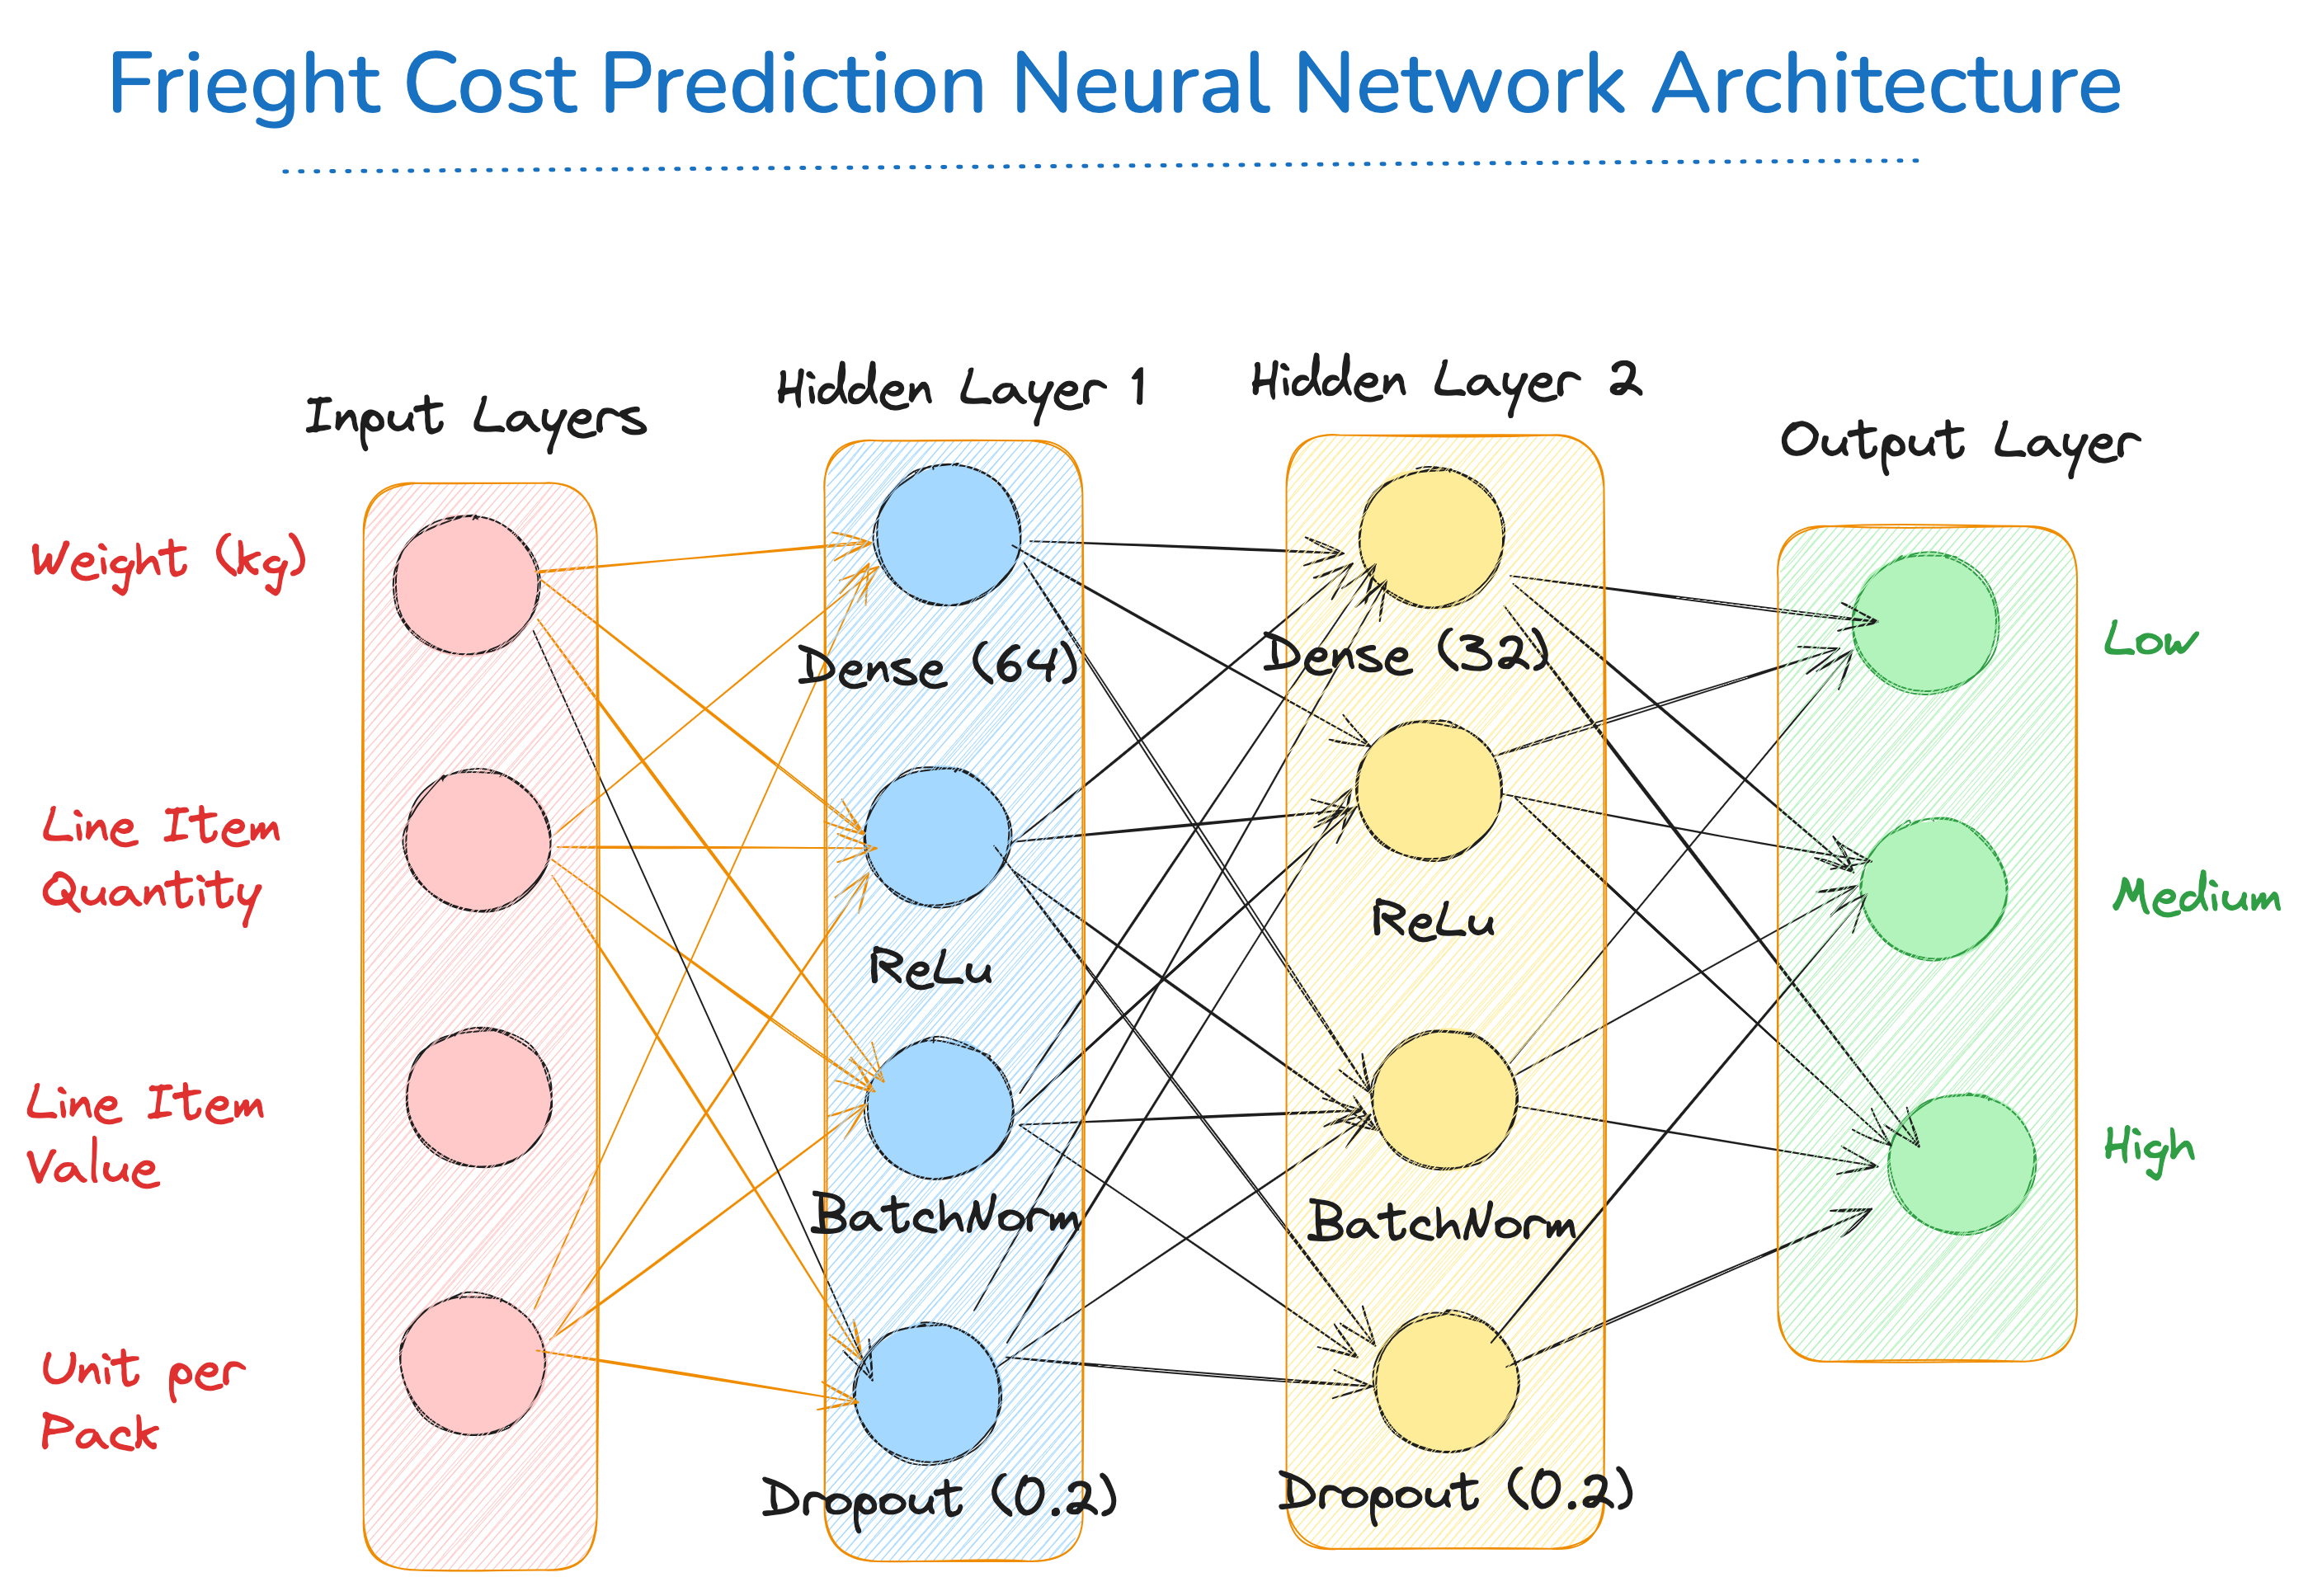

#Task: Define a function that creates models without and With specified Optimization techniques


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [39]:

def create_base_model(input_dim, n_classes=3):
    """
    Creates a basic model without optimization techniques
    """
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer='sgd',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [40]:
def create_optimized_model(input_dim, config):
    """
    Creates a model with specified optimization techniques
    """
    model = Sequential()

    # Input layer
    model.add(Dense(config['units'][0], activation='relu', input_dim=input_dim))
    if config.get('batch_norm'):
        model.add(BatchNormalization())
    if config.get('dropout'):
        model.add(Dropout(config['dropout_rate']))

    # Hidden layers
    for units in config['units'][1:]:
        model.add(Dense(units, activation='relu'))
        if config.get('batch_norm'):
            model.add(BatchNormalization())
        if config.get('dropout'):
            model.add(Dropout(config['dropout_rate']))

    # Output layer
    model.add(Dense(3, activation='softmax'))

    # Compile model
    if config['optimizer'] == 'adam':
        opt = Adam(learning_rate=config['learning_rate'])
    elif config['optimizer'] == 'rmsprop':
        opt = RMSprop(learning_rate=config['learning_rate'])
    else:
        opt = SGD(learning_rate=config['learning_rate'])

    model.compile(
        optimizer=opt,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [41]:
def get_callbacks(use_early_stopping=True, use_lr_schedule=True):
    """
    Creates callbacks for model training
    """
    callbacks = []

    if use_early_stopping:
        callbacks.append(EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ))

    if use_lr_schedule:
        callbacks.append(ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        ))

    return callbacks

In [42]:
# Create base model
base_model = create_base_model(X_train.shape[1])

# Create optimized model with specific configuration
config = {
    'units': [64, 48, 32],
    'optimizer': 'adam',
    'learning_rate': 0.001,
    'dropout': True,
    'dropout_rate': 0.2,
    'batch_norm': True
}
optimized_model = create_optimized_model(X_train.shape[1], config)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Task: Print out the Final Model Accuracy and plot the Loss curve

For base model

In [57]:
def train_and_plot_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test,
                          model_name, epochs=50, batch_size=32):
    """
    Train model and plot metrics
    """
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n{model_name} Final Results:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Create figure
    plt.figure(figsize=(12, 5))

    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Save the plot (create a new figure to save)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}_metrics.png')
    plt.close()

    return history, test_accuracy, test_loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Final Results Summary:
--------------------------------------------------
Model                          | Accuracy   | Loss      
--------------------------------------------------


For optimized Model

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

In [44]:
def create_model_instance(config):
    """
    Create model with specified optimization techniques
    """
    model = Sequential()

    # Input layer
    model.add(Dense(
        config['units'][0],
        activation='relu',
        input_dim=config['input_dim'],
        kernel_regularizer=config.get('regularizer')
    ))

    if config.get('batch_norm'):
        model.add(BatchNormalization())
    if config.get('dropout'):
        model.add(Dropout(config['dropout']))

    # Hidden layers
    for units in config['units'][1:-1]:
        model.add(Dense(
            units,
            activation='relu',
            kernel_regularizer=config.get('regularizer')
        ))
        if config.get('batch_norm'):
            model.add(BatchNormalization())
        if config.get('dropout'):
            model.add(Dropout(config['dropout']))

    # Output layer
    model.add(Dense(3, activation='softmax'))

    # Compile model
    model.compile(
        optimizer=config['optimizer'],
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



Starting optimization combinations training...

Training Adam_Dropout_BatchNorm...
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3724 - loss: 1.4035 - val_accuracy: 0.4325 - val_loss: 1.0813 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4395 - loss: 1.1378 - val_accuracy: 0.4526 - val_loss: 1.0261 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4944 - loss: 1.0521 - val_accuracy: 0.5096 - val_loss: 0.9685 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5381 - loss: 0.9716 - val_accuracy: 0.5608 - val_loss: 0.9123 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5308 - loss: 0.9515 - val_accuracy: 0.5901 - val_loss: 0.8638 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5700 - loss: 0.9176 - val_accuracy: 0.5985 - val_loss: 0.8331 - learning_rate: 0.0010
Epoch


Training RMSprop_L2_Deep...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3568 - loss: 2.3731 - val_accuracy: 0.4191 - val_loss: 1.1354 - learning_rate: 0.0050
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4382 - loss: 1.1080 - val_accuracy: 0.4023 - val_loss: 1.1165 - learning_rate: 0.0050
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4948 - loss: 1.0531 - val_accuracy: 0.5826 - val_loss: 0.9745 - learning_rate: 0.0050
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5294 - loss: 1.0244 - val_accuracy: 0.4786 - val_loss: 1.0373 - learning_rate: 0.0050
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5229 - loss: 1.0094 - val_accuracy: 0.5943 - val_loss: 0.9354 - learning_rate: 0.0050
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5564 - loss: 0.9805 - val_accuracy: 0.5650 - val_loss: 0.9590 - learning_rate: 0.0050
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5554 - loss: 0.9705 - val_accurac


Training SGD_Momentum_BatchNorm...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4129 - loss: 1.1598 - val_accuracy: 0.3630 - val_loss: 1.3942 - learning_rate: 0.0100
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4741 - loss: 1.0050 - val_accuracy: 0.3831 - val_loss: 1.7541 - learning_rate: 0.0100
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4889 - loss: 0.9942 - val_accuracy: 0.3906 - val_loss: 1.7958 - learning_rate: 0.0100
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5212 - loss: 0.9562 - val_accuracy: 0.3705 - val_loss: 1.5279 - learning_rate: 0.0100
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5262 - loss: 0.9488 - val_accuracy: 0.4384 - val_loss: 1.0760 - learning_rate: 0.0100
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5412 - loss: 0.9537 - val_accuracy: 0.4057 - val_loss: 1.3770 - learning_rate: 0.0100
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5406 - loss: 0.9281 - val_accurac


Training Adam_ElasticNet_Dropout...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3354 - loss: 15.6586 - val_accuracy: 0.3361 - val_loss: 5.4837 - learning_rate: 0.0020
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3353 - loss: 4.4511 - val_accuracy: 0.3185 - val_loss: 2.4098 - learning_rate: 0.0020
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3495 - loss: 2.0977 - val_accuracy: 0.3437 - val_loss: 1.4955 - learning_rate: 0.0020
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3286 - loss: 1.4084 - val_accuracy: 0.3185 - val_loss: 1.2437 - learning_rate: 0.0020
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3455 - loss: 1.2199 - val_accuracy: 0.3185 - val_loss: 1.1765 - learning_rate: 0.0020
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3301 - loss: 1.1690 - val_accuracy: 0.3185 - val_loss: 1.1530 - learning_rate: 0.0020
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3448 - loss: 1.1489 - val_accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training RMSprop_L1_BatchNorm...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4109 - loss: 6.8799 - val_accuracy: 0.3948 - val_loss: 5.2764 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5513 - loss: 4.7711 - val_accuracy: 0.4426 - val_loss: 3.9636 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5843 - loss: 3.6089 - val_accuracy: 0.4593 - val_loss: 3.2367 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5980 - loss: 2.9247 - val_accuracy: 0.4677 - val_loss: 2.8268 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5806 - loss: 2.4837 - val_accuracy: 0.4434 - val_loss: 2.3404 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6086 - loss: 2.1177 - val_accuracy: 0.5063 - val_loss: 2.0181 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6057 - loss: 1.8525 - val_accurac


Optimization Results Summary:
                     Model Optimizer  accuracy      loss        f1  precision  \
0   Adam_Dropout_BatchNorm      Adam  0.699916  0.680403  0.692699   0.693633   
1          RMSprop_L2_Deep   RMSprop  0.650461  0.815055  0.610064   0.637507   
2   SGD_Momentum_BatchNorm       SGD  0.688181  0.735830  0.684582   0.685669   
3  Adam_ElasticNet_Dropout      Adam  0.335289  1.099971  0.168381   0.112419   
4     RMSprop_L1_BatchNorm   RMSprop  0.730930  0.693038  0.727437   0.726207   

     recall  
0  0.699916  
1  0.650461  
2  0.688181  
3  0.335289  
4  0.730930  


In [58]:
def train_and_evaluate(model, config, X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Train and evaluate model with full metrics and visualization
    """
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    # Train model
    print(f"\nTraining {config['name']}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_classes, average='weighted'
    )

    # Plot training history
    plt.figure(figsize=(15, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{config["name"]} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{config["name"]} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{config["name"]}_training_history.png')
    plt.close()

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{config["name"]} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{config["name"]}_confusion_matrix.png')
    plt.close()

    return {
        'accuracy': test_accuracy,
        'loss': test_loss,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'history': history.history
    }


In [ ]:
def get_model_configs(input_dim):
    return [
        {
            'name': 'Adam_Dropout_BatchNorm',
            'input_dim': input_dim,
            'units': [64, 48, 32],
            'optimizer': Adam(learning_rate=0.001),
            'dropout': 0.2,
            'batch_norm': True,
            'regularizer': None
        },
        {
            'name': 'RMSprop_L2_Deep',
            'input_dim': input_dim,
            'units': [128, 96, 64, 32],
            'optimizer': RMSprop(learning_rate=0.005),
            'dropout': None,
            'batch_norm': False,
            'regularizer': tf.keras.regularizers.l2(0.01)
        },
        {
            'name': 'SGD_Momentum_BatchNorm',
            'input_dim': input_dim,
            'units': [96, 64, 48, 32, 16],
            'optimizer': SGD(learning_rate=0.01, momentum=0.9),
            'dropout': None,
            'batch_norm': True,
            'regularizer': None
        },
        {
            'name': 'Adam_ElasticNet_Dropout',
            'input_dim': input_dim,
            'units': [128, 96, 64, 32],
            'optimizer': Adam(learning_rate=0.002),
            'dropout': 0.3,
            'batch_norm': False,
            'regularizer': tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)
        },
        {
            'name': 'RMSprop_L1_BatchNorm',
            'input_dim': input_dim,
            'units': [64, 48, 32, 16],
            'optimizer': RMSprop(learning_rate=0.001),
            'dropout': None,
            'batch_norm': True,
            'regularizer': tf.keras.regularizers.l1(0.01)
        }
    ]

In [59]:
def run_optimization_combinations(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Run all optimization combinations and collect results
    """
    results = []
    configs = get_model_configs(X_train.shape[1])

    for config in configs:
        # Create and train model
        model = create_model_instance(config)
        model_results = train_and_evaluate(
            model, config, X_train, y_train, X_val, y_val, X_test, y_test
        )

        # Save results
        results.append({
            'Model': config['name'],
            'Optimizer': config['optimizer'].__class__.__name__,
            'Learning Rate': config['optimizer'].learning_rate.numpy(),
            'Dropout': config.get('dropout', 'None'),
            'Batch Norm': config.get('batch_norm', False),
            'Regularization': config.get('regularizer', 'None'),
            **model_results
        })

        # Save model
        model.save(f'{config["name"]}_model.h5')

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    print("\nOptimization Results Summary:")
    print(results_df[['Model', 'Optimizer', 'accuracy', 'loss', 'f1', 'precision', 'recall']])

    # Save results
    results_df.to_csv('optimization_results.csv', index=False)

    return results_df

In [60]:
# Run the optimization combinations
print("Starting optimization combinations training...")
results = run_optimization_combinations(X_train, y_train, X_val, y_val, X_test, y_test)

Starting optimization combinations training...

Training Adam_Dropout_BatchNorm...
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3633 - loss: 1.3787 - val_accuracy: 0.3982 - val_loss: 1.1294 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4378 - loss: 1.1395 - val_accuracy: 0.4895 - val_loss: 0.9969 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4716 - loss: 1.0446 - val_accuracy: 0.4962 - val_loss: 0.9719 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4695 - loss: 1.0333 - val_accuracy: 0.5717 - val_loss: 0.9321 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5234 - loss: 0.9865 - val_accuracy: 0.5457 - val_loss: 0.9255 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5321 - loss: 0.9746 - val_accuracy: 0.5775 - val_loss: 0.9049 - learning_rate: 0.0010
Epoch


Training RMSprop_L2_Deep...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3544 - loss: 2.8342 - val_accuracy: 0.3277 - val_loss: 1.2272 - learning_rate: 0.0050
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4140 - loss: 1.1403 - val_accuracy: 0.4753 - val_loss: 1.0544 - learning_rate: 0.0050
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4473 - loss: 1.0843 - val_accuracy: 0.4292 - val_loss: 1.0831 - learning_rate: 0.0050
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4696 - loss: 1.0659 - val_accuracy: 0.4334 - val_loss: 1.0873 - learning_rate: 0.0050
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5041 - loss: 1.0328 - val_accuracy: 0.5876 - val_loss: 0.9856 - learning_rate: 0.0050
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5053 - loss: 1.0262 - val_accuracy: 0.5281 - val_loss: 0.9778 - learning_rate: 0.0050
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5127 - loss: 1.0069 - val_accurac


Training SGD_Momentum_BatchNorm...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3858 - loss: 1.2228 - val_accuracy: 0.3722 - val_loss: 1.2999 - learning_rate: 0.0100
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4935 - loss: 0.9935 - val_accuracy: 0.3806 - val_loss: 1.1962 - learning_rate: 0.0100
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5139 - loss: 0.9799 - val_accuracy: 0.4702 - val_loss: 1.1003 - learning_rate: 0.0100
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5256 - loss: 0.9681 - val_accuracy: 0.4334 - val_loss: 1.1350 - learning_rate: 0.0100
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 0.9584 - val_accuracy: 0.4258 - val_loss: 1.1210 - learning_rate: 0.0100
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5335 - loss: 0.9470 - val_accuracy: 0.4174 - val_loss: 1.2747 - learning_rate: 0.0100
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5508 - loss: 0.9134 - val_accurac


Training Adam_ElasticNet_Dropout...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3320 - loss: 16.1129 - val_accuracy: 0.3168 - val_loss: 6.0841 - learning_rate: 0.0020
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3396 - loss: 5.0641 - val_accuracy: 0.3185 - val_loss: 2.9373 - learning_rate: 0.0020
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3402 - loss: 2.5642 - val_accuracy: 0.3185 - val_loss: 1.7775 - learning_rate: 0.0020
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3454 - loss: 1.6386 - val_accuracy: 0.3361 - val_loss: 1.3597 - learning_rate: 0.0020
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3321 - loss: 1.3152 - val_accuracy: 0.3185 - val_loss: 1.2231 - learning_rate: 0.0020
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3168 - loss: 1.2075 - val_accuracy: 0.3185 - val_loss: 1.1748 - learning_rate: 0.0020
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3344 - loss: 1.1680 - val_accura

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training RMSprop_L1_BatchNorm...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4457 - loss: 6.6555 - val_accuracy: 0.4409 - val_loss: 4.9135 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5338 - loss: 4.4269 - val_accuracy: 0.4107 - val_loss: 3.5847 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5744 - loss: 3.2409 - val_accuracy: 0.4870 - val_loss: 2.8508 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5774 - loss: 2.6094 - val_accuracy: 0.4518 - val_loss: 2.3971 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5827 - loss: 2.1920 - val_accuracy: 0.4409 - val_loss: 2.1147 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6019 - loss: 1.8944 - val_accuracy: 0.5432 - val_loss: 1.7743 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5852 - loss: 1.6828 - val_accurac


Optimization Results Summary:
                     Model Optimizer  accuracy      loss        f1  precision  \
0   Adam_Dropout_BatchNorm      Adam  0.715842  0.658344  0.708991   0.708448   
1          RMSprop_L2_Deep   RMSprop  0.647946  0.825028  0.610318   0.634191   
2   SGD_Momentum_BatchNorm       SGD  0.664711  0.768340  0.652221   0.655069   
3  Adam_ElasticNet_Dropout      Adam  0.335289  1.099200  0.168381   0.112419   
4     RMSprop_L1_BatchNorm   RMSprop  0.726739  0.704356  0.724623   0.723722   

     recall  
0  0.715842  
1  0.647946  
2  0.664711  
3  0.335289  
4  0.726739  


call all the instance functions

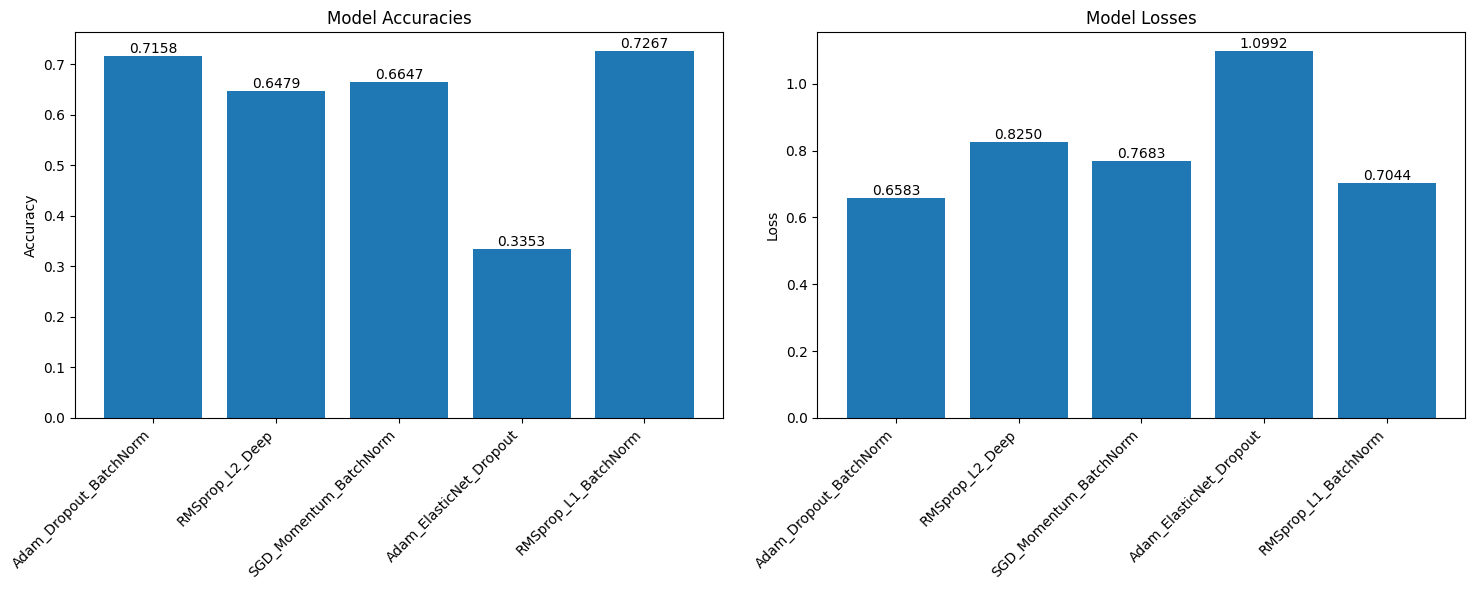

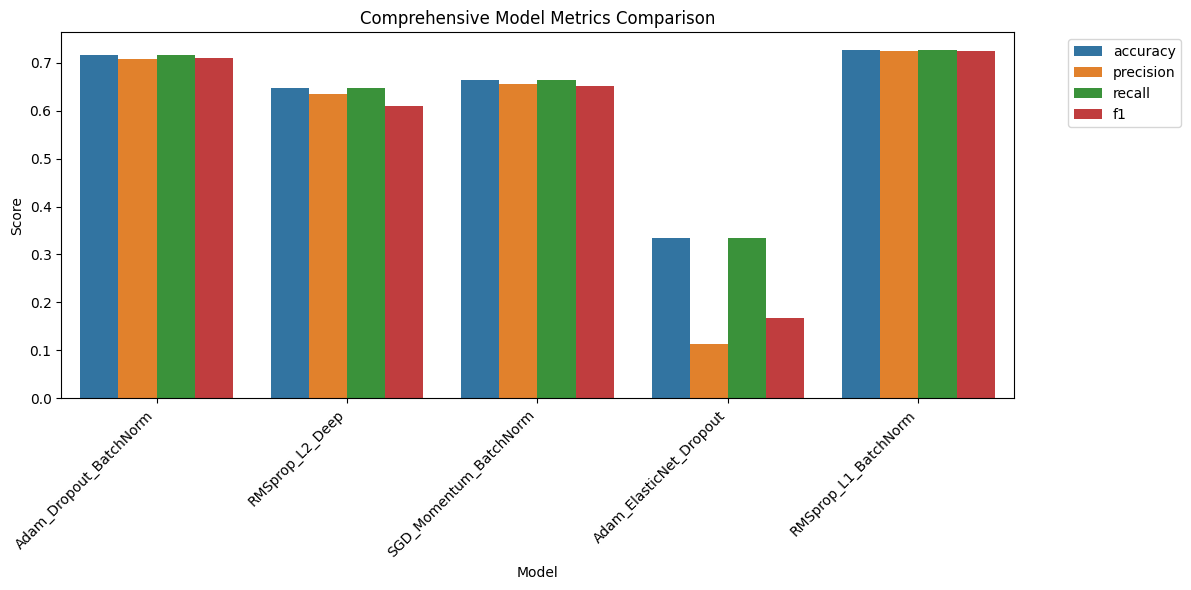


Detailed Results:
                  Model  accuracy     loss  precision   recall       f1
 Adam_Dropout_BatchNorm  0.715842 0.658344   0.708448 0.715842 0.708991
        RMSprop_L2_Deep  0.647946 0.825028   0.634191 0.647946 0.610318
 SGD_Momentum_BatchNorm  0.664711 0.768340   0.655069 0.664711 0.652221
Adam_ElasticNet_Dropout  0.335289 1.099200   0.112419 0.335289 0.168381
   RMSprop_L1_BatchNorm  0.726739 0.704356   0.723722 0.726739 0.724623

Best Performing Model:
Model: RMSprop_L1_BatchNorm
Accuracy: 0.7267
Loss: 0.7044
F1 Score: 0.7246


In [61]:
def plot_all_models_results():
    """
    Plot results from saved optimization_results.csv
    """
    # Read the results
    results_df = pd.read_csv('/content/optimization_results.csv')

    # Create figure for metrics comparison
    plt.figure(figsize=(15, 6))

    # Plot accuracies and losses
    metrics = ['accuracy', 'loss']
    plt.subplot(1, 2, 1)
    bars = plt.bar(results_df['Model'], results_df['accuracy'])
    plt.title('Model Accuracies')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Accuracy')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')

    plt.subplot(1, 2, 2)
    bars = plt.bar(results_df['Model'], results_df['loss'])
    plt.title('Model Losses')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Loss')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Create comprehensive metrics comparison
    plt.figure(figsize=(12, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    df_melted = pd.melt(results_df,
                        id_vars=['Model'],
                        value_vars=metrics,
                        var_name='Metric',
                        value_name='Score')

    sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted)
    plt.title('Comprehensive Model Metrics Comparison')
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Print tabulated results
    print("\nDetailed Results:")
    print(results_df[['Model', 'accuracy', 'loss', 'precision', 'recall', 'f1']].to_string(index=False))

    # Identify best model
    best_model = results_df.loc[results_df['accuracy'].idxmax()]
    print("\nBest Performing Model:")
    print(f"Model: {best_model['Model']}")
    print(f"Accuracy: {best_model['accuracy']:.4f}")
    print(f"Loss: {best_model['loss']:.4f}")
    print(f"F1 Score: {best_model['f1']:.4f}")

# Plot the results
plot_all_models_results()

In [ ]:
import pandas as pd
import tensorflow as tf
import os

In [47]:

def determine_best_model():
    """
    Read the optimization results and determine the best model
    """
    # Read the results CSV
    results_df = pd.read_csv('/content/optimization_results.csv')

    # Find the best model based on accuracy
    best_model_info = results_df.loc[results_df['accuracy'].idxmax()]

    print("\nBest Model Information:")
    print(f"Model Name: {best_model_info['Model']}")
    print(f"Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"Loss: {best_model_info['loss']:.4f}")
    print(f"F1 Score: {best_model_info['f1']:.4f}")

    # Load the best model
    best_model_path = f"{best_model_info['Model']}_model.h5"

    if os.path.exists(best_model_path):
        best_model = tf.keras.models.load_model(best_model_path)

        # Save it as the best model
        best_model.save('best_model.h5')
        print(f"\nBest model saved as 'best_model.h5'")

        return best_model, best_model_info
    else:
        print(f"\nError: Model file {best_model_path} not found!")
        return None, best_model_info


Determining and saving best model...

Best Model Information:
Model Name: RMSprop_L1_BatchNorm
Accuracy: 0.7309
Loss: 0.6930
F1 Score: 0.7274

Best model saved as 'best_model.h5'



Best model summary saved to 'best_model_summary.txt'

Best model successfully identified and saved!
You can now use 'best_model.h5' for making predictions.


In [ ]:
def save_best_model_summary():
    """
    Create a summary file for the best model
    """
    try:
        best_model, best_info = determine_best_model()

        if best_model is not None:
            # Save model summary to a text file
            with open('/content/best_model_summary.txt', 'w') as f:
                f.write("Best Model Summary\n")
                f.write("=================\n\n")
                f.write(f"Model Name: {best_info['Model']}\n")
                f.write(f"Accuracy: {best_info['accuracy']:.4f}\n")
                f.write(f"Loss: {best_info['loss']:.4f}\n")
                f.write(f"F1 Score: {best_info['f1']:.4f}\n")
                f.write(f"Optimizer: {best_info['Optimizer']}\n")
                f.write(f"Learning Rate: {best_info['Learning Rate']}\n")
                if 'Regularization' in best_info:
                    f.write(f"Regularization: {best_info['Regularization']}\n")
                if 'Other Techniques' in best_info:
                    f.write(f"Other Techniques: {best_info['Other Techniques']}\n")

                f.write("\nModel Architecture:\n")
                best_model.summary(print_fn=lambda x: f.write(x + '\n'))

            print("\nBest model summary saved to 'best_model_summary.txt'")
            return best_model
    except Exception as e:
        print(f"Error saving best model summary: {str(e)}")
        return None


In [ ]:
# Run this after training all models
if __name__ == "__main__":
    print("Determining and saving best model...")
    best_model = save_best_model_summary()

    if best_model is not None:
        print("\nBest model successfully identified and saved!")
        print("You can now use 'best_model.h5' for making predictions.")

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [49]:
def load_and_predict(model_path, X_test, y_test):
    """
    Load the best model and make predictions

    Args:
        model_path: Path to saved model
        X_test: Test features
        y_test: True labels
    """
    print("Loading best model...")
    best_model = tf.keras.models.load_model(model_path)

    # Make predictions
    print("\nMaking predictions...")
    y_pred_proba = best_model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Calculate prediction confidence
    confidence = np.max(y_pred_proba, axis=1)

    # Create results DataFrame
    results_df = pd.DataFrame({
        'True_Label': y_test,
        'Predicted_Label': y_pred,
        'Confidence': confidence
    })

    # Print detailed metrics
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Create confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - Best Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('best_model_confusion_matrix.png')
    plt.close()

    # Plot confidence distribution
    plt.figure(figsize=(10, 6))
    plt.hist(confidence, bins=20, edgecolor='black')
    plt.title('Prediction Confidence Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.savefig('prediction_confidence_distribution.png')
    plt.close()

    # Analyze incorrect predictions
    incorrect_predictions = results_df[results_df['True_Label'] != results_df['Predicted_Label']]
    print("\nIncorrect Predictions Analysis:")
    print(f"Total incorrect predictions: {len(incorrect_predictions)}")
    print(f"Accuracy: {1 - len(incorrect_predictions)/len(results_df):.4f}")

    # Save detailed results
    results_df.to_csv('prediction_results.csv', index=False)
    incorrect_predictions.to_csv('incorrect_predictions.csv', index=False)

    return results_df, best_model


In [ ]:
def analyze_predictions(results_df):
    """
    Analyze prediction results in detail
    """
    print("\nDetailed Prediction Analysis:")

    # Accuracy by class
    print("\nAccuracy by Class:")
    for label in results_df['True_Label'].unique():
        class_data = results_df[results_df['True_Label'] == label]
        accuracy = sum(class_data['True_Label'] == class_data['Predicted_Label']) / len(class_data)
        print(f"Class {label}: {accuracy:.4f}")

    # Confidence analysis
    print("\nConfidence Analysis:")
    print(f"Mean confidence: {results_df['Confidence'].mean():.4f}")
    print(f"Median confidence: {results_df['Confidence'].median():.4f}")

    # High confidence mistakes
    high_conf_mistakes = results_df[
        (results_df['True_Label'] != results_df['Predicted_Label']) &
        (results_df['Confidence'] > 0.8)
    ]
    print(f"\nHigh confidence mistakes (>0.8): {len(high_conf_mistakes)}")

    # Plot confidence vs correctness
    plt.figure(figsize=(10, 6))
    correct = results_df['True_Label'] == results_df['Predicted_Label']
    plt.hist([
        results_df[correct]['Confidence'],
        results_df[~correct]['Confidence']
    ], label=['Correct', 'Incorrect'], bins=20, alpha=0.7)
    plt.title('Confidence Distribution - Correct vs Incorrect Predictions')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.legend()
    plt.savefig('confidence_analysis.png')
    plt.close()


In [ ]:
def predict_new_data(model, new_data, class_labels=None):
    """
    Make predictions on new data

    Args:
        model: Loaded model
        new_data: New features to predict
        class_labels: Optional mapping of numeric labels to class names
    """
    # Make predictions
    predictions_proba = model.predict(new_data)
    predictions = np.argmax(predictions_proba, axis=1)
    confidence = np.max(predictions_proba, axis=1)

    # Create results DataFrame
    results = pd.DataFrame({
        'Predicted_Class': predictions,
        'Confidence': confidence
    })

    # Map numeric labels to class names if provided
    if class_labels is not None:
        results['Predicted_Class'] = results['Predicted_Class'].map(class_labels)

    return results


In [50]:
results_df, best_model = load_and_predict('/content/best_model.h5', X_test, y_test)

Loading best model...

Making predictions...
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       391
           1       0.80      0.82      0.81       400
           2       0.63      0.56      0.60       402

    accuracy                           0.73      1193
   macro avg       0.73      0.73      0.73      1193
weighted avg       0.73      0.73      0.73      1193


Incorrect Predictions Analysis:
Total incorrect predictions: 321
Accuracy: 0.7309


## Machine Learning Algorithm

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [52]:
def train_xgboost_model(X_train, X_test, y_train, y_test):
    """
    Train and tune XGBoost model with GridSearchCV
    """
    # Define parameter grid (reduced for faster execution)
    param_grid = {
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1],
        'n_estimators': [100, 200],
        'min_child_weight': [1, 3],
        'gamma': [0, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }

    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=2
    )

    # Fit the model
    print("Training XGBoost model with GridSearchCV...")
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)

    # Print results
    print("\nBest parameters found:")
    print(grid_search.best_params_)
    print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Create confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - XGBoost')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('xgboost_confusion_matrix.png')
    plt.close()

    # Feature importance plot
    plt.figure(figsize=(10, 6))
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance - XGBoost')
    plt.tight_layout()
    plt.savefig('xgboost_feature_importance.png')
    plt.close()

    # Save model
    best_model.save_model('/content/best_xgboost_model.json')

    return {
        'model': best_model,
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'feature_importance': feature_importance
    }

if __name__ == "__main__":
    print("Training XGBoost model...")
    xgboost_results = train_xgboost_model(X_train, X_test, y_train, y_test)

    # Save results to CSV
    results_df = pd.DataFrame({
        'Model': ['XGBoost'],
        'Best CV Score': [xgboost_results['best_score']],
        'Parameters': [str(xgboost_results['best_params'])]
    })
    results_df.to_csv('/content/xgboost_results.csv', index=False)

    print("\nResults saved to 'xgboost_results.csv'")

Training XGBoost model...
Training XGBoost model with GridSearchCV...
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:37:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best parameters found:
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}

Best cross-validation score: 0.7487

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.79      0.80       391
           1       0.85      0.81      0.83       400
           2       0.65      0.69      0.67       402

    accuracy                           0.76      1193
   macro avg       0.77      0.76      0.77      1193
weighted avg       0.77      0.76      0.77      1193


Results saved to 'xgboost_results.csv'


Congratulations!!


saving the content locally

In [53]:
!zip -r /content/model_data.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.last_update_check.json (deflated 22%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.02.20/ (stored 0%)
  adding: content/.config/logs/2025.02.20/14.24.10.539232.log (deflated 57%)
  adding: content/.config/logs/2025.02.20/14.23.58.333263.log (deflated 58%)
  adding: content/.config/logs/2025.02.20/14.23.42.557542.log (deflated 58%)
  adding: content/.config/logs/2025.02.20/14.23.54.466137.log (deflated 87%)
  adding: content/.config/logs/2025.02.20/14.23.09.448625.log (deflated 92%)
  adding: content/.config/logs/2025.02.20/14.24.11.360033.log (deflated 56%)
  adding: content/.config